In [60]:
import json
import matplotlib.pylab as plt
import matplotlib
from urllib.request import urlopen
import numpy as np

In [24]:
# Load data
file = urlopen("https://raw.githubusercontent.com/MystenLabs/fastcrypto/gh-pages/benchmarks/history/7dc17afca3f9bfcd2a0a712e8cc6da3ad745eb90.json")

In [25]:
# Structure data
data = {}

for line in file:
    bench = json.loads(line)
    if bench['reason'] != 'benchmark-complete':
        continue
    value = bench['mean']['estimate'] / 1000 # Convert to ms
    key = bench['id']
    description = key.split('/')
    group = description[0]
        
    if group not in data:
        data[group] = {}
        
    scheme = description[1]
    if scheme not in data[group]:
        data[group][scheme] = {}
        
    # Benchmarks of batch verification has 3 parts (type/scheme/batch_size)
    if len(description) == 3:
        batch_size = int(description[2])
        data[group][scheme][batch_size] = value
    else:
        data[group][scheme] = value       

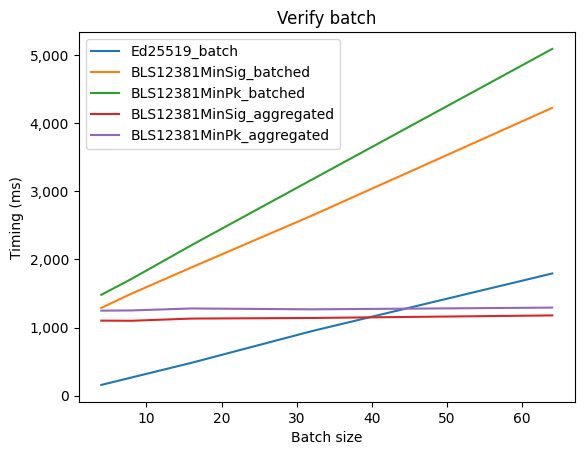

In [35]:
# Plot batch verification
group = "Verify batch"
d = data[group]

fig, ax = plt.subplots()

for scheme in d:
    x = d[scheme].keys()
    y = d[scheme].values()
    ax.plot(x,y, label = scheme)

ax.set_title(group)
ax.legend(loc='upper left')
ax.set_xlabel('Batch size')
ax.set_ylabel('Timing (ms)')
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

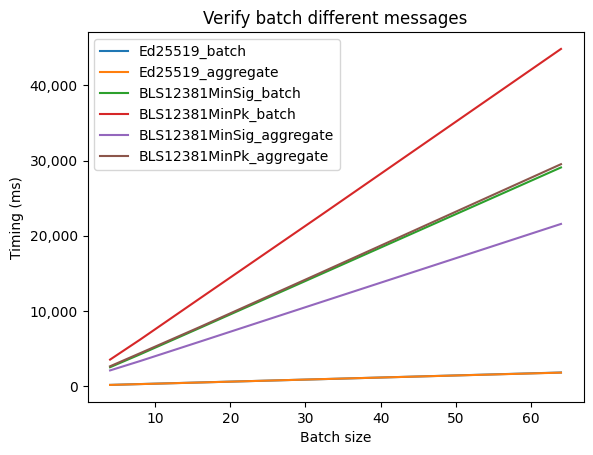

In [37]:
# Plot batch verification different messages
group = "Verify batch different messages"
d = data[group]

fig, ax = plt.subplots()

for scheme in d:
    x = d[scheme].keys()
    y = d[scheme].values()
    ax.plot(x,y, label = scheme)

ax.set_title(group)
ax.legend(loc='upper left')
ax.set_xlabel('Batch size')
ax.set_ylabel('Timing (ms)')
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

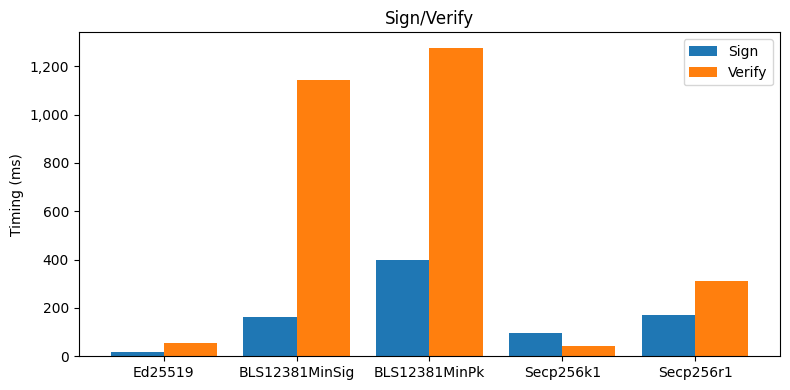

In [71]:
# Plot signing

fig, ax = plt.subplots(figsize=(8, 4))
width = 0.4

group = "Sign"
d = data[group]
x_axis = np.arange(len(d.keys()))
ax.bar(x_axis - width / 2, d.values(), width, label = group)

group = "Verify"
d = data[group]
ax.bar(x_axis + width / 2, d.values(), width, label = group)

ax.set_title("Sign/Verify")
ax.set_ylabel('Timing (ms)')
ax.legend()
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylim(ymin=0)

ax.set_xticks(x_axis, d.keys())

fig.tight_layout()